In [1]:
%matplotlib inline

import pickle
import argparse
from os.path import basename, join
from itertools import repeat
import torch
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.colors as colors
from tqdm import tqdm

plt.style.use('seaborn-pastel')
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage[T1]{fontenc}',
    r'\usepackage{times}',
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}',
]


matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 18

In [2]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either
    side from a prescribed midpoint value)

    e.g.
    im=ax1.imshow(arr, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


def config(path):
    return tuple(basename(path).split('-')[:2])


def draw_square(ax, i, j, **kwargs):
    rect = patches.Rectangle((i - 0.5, j - 0.5), 1, 1, fill=False, **kwargs)
    ax.add_patch(rect)


def draw_all_squares(ax, M):
    for ii in range(M.shape[0]):
        for jj in range(M.shape[1]):
            if M[ii, jj] > 0:
                draw_square(ax, jj, ii, color="#aaaaaa", lw=1, alpha=1)


def draw_plot(plot, att_type, layer, head, fontsize=10, rotation=45, size=5):
    
    layer -= 1
    head -= 1
    fig = plt.figure(figsize=(size, size))
    
    if att_type == 'enc_self':
        src = plot['src']
        tgt = plot['src']
    elif att_type == 'dec_self':
        src = plot['tgt']
        tgt = plot['tgt']
    else:
        src = plot['src']
        tgt = plot['tgt']
        
    x_labels = [''] + src
    y_labels = [''] + tgt
    
    attn_matrix = plot["attn"]['enc_self'][layer, head]

    ax = fig.add_subplot(1, 1, 1)
    cmap = plt.cm.PuOr_r  # OrRd
    cax = ax.matshow(
        attn_matrix, cmap=cmap, clim=(-1, 1),
        norm=MidpointNormalize(midpoint=0,vmin=1, vmax=1)
    )
    draw_all_squares(ax, attn_matrix)
    # fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(
        x_labels,
        rotation=rotation,
        fontsize=fontsize,
        horizontalalignment='left'
    )
    ax.set_yticklabels(y_labels, fontsize=fontsize)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    if 1 == 1:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    else:
        ax.yaxis.set_major_locator(ticker.NullLocator())

    plt.show()
    #plt.savefig(path, bbox_inches='tight')

In [3]:
stats_dict = {'softmax': 'attns_wmt14-softmax.pkl',
              '1.5-entmax': 'attns_wmt14-15-entmax.pkl',
              'alpha-entmax': 'attns_wmt14-alpha-entmax.pkl'}

In [4]:
attns_per_example = {}

for activation, filename in stats_dict.items(): 
    with open('data/' + filename, 'rb') as f:
        dataset_attns = pickle.load(f)
    attns_per_example[activation] = dataset_attns
    
del dataset_attns

### Alpha Distribution

In [16]:
with open('data/alphas_wmt14-alpha-entmax.pkl', 'rb') as f:
    alphas = pickle.load(f)

In [44]:
alphas['enc_self'][5][6]

1.3387105

In [24]:
alphas['enc_self'][2 - 1][8 - 1]

1.9092915

In [ ]:
attn_types = ['enc_self', 'dec_context', 'dec_self']

_, axes = plt.subplots(3, 1, figsize=(7, 7), sharey=True, sharex=True, constrained_layout=True)

for ax_i, attn_type in enumerate(attn_types):
    alphas_attn = np.concatenate(alphas[attn_type])
    ax = axes[ax_i]

    ax.hist(alphas_attn, bins=np.linspace(1, 2, 16))


print(attn_types)
labels = ['Encoder\nSelf-Attention', 'Context\nAttention', 'Decoder\nSelf-Attention']

for row, label in zip(axes, labels):
    row.set_ylabel(label)

axes[2].set_xlabel(r"$\alpha$")

plt.savefig('paper-entmax-transformers/figures/hist_alphas.pdf', bbox_inches='tight')

In [ ]:
for activation, dataset_attns in attns_per_example.items():
    print("activation: %s, length: %i" % (activation, len(dataset_attns)))

#### Head Sparsity

In [ ]:
attn_types = ['enc_self', 'dec_context', 'dec_self']

densities_per_attn_type = {}

for attn_type in attn_types:
    
    densities_per_activation = {}

    for activation, dataset_attns in attns_per_example.items():

        densities = np.zeros((6, 8))
        sum_of_lens = 0

        for idx in tqdm(range(len(dataset_attns))):
            attn = dataset_attns[idx]['attn'][attn_type]
            tgt_size = attn.shape[-2]
            src_size = attn.shape[-1]
            grid_size = tgt_size*src_size
            if attn_type == 'dec_self':
                grid_size = (grid_size + src_size)/2

            sum_of_lens += grid_size

            for ii, layer in enumerate(attn):
                for jj, head in enumerate(layer):
                    attended = (head.flatten() > 0).sum()
                    densities[ii, jj] += attended

        #densities = (densities - 1) / (sum_of_lens - 1)
        densities = (densities) / (sum_of_lens)
        densities_per_activation[activation] = densities
        
    densities_per_attn_type[attn_type] = densities_per_activation

In [ ]:
for attn_type in attn_types:
    print(attn_type)
    densities_per_activation = densities_per_attn_type[attn_type]

    for activation in ['1.5-entmax', 'alpha-entmax']:
        print(activation)
        densities = densities_per_activation[activation]

        for ii, layer in enumerate(densities):
            print('Layer %i' % (ii+1))
            density_and_ix = [(x, k) for k, x in enumerate(layer)]
            density_and_ix.sort()
            #srt_layer = sort(layer)
            #argsrt_layer = np.argsort(layer)
            for head, jj in density_and_ix:
                print('\tHead %i Density: %0.2f' % (jj+1, head))

In [ ]:
cmap_d = [plt.cm.copper_r(k) for k in np.linspace(0, .9, 8)]

In [ ]:
_, axes = plt.subplots(3, 2, figsize=(7, 9), sharey=True, sharex=True, constrained_layout=True)

for ax_i, attn_type in enumerate(attn_types):
    densities_per_activation = densities_per_attn_type[attn_type]
    for ax_j, activation in enumerate(['1.5-entmax', 'alpha-entmax']):
        ax = axes[ax_i][ax_j]

        densities = densities_per_activation[activation]
        means = []
        each = np.zeros_like(densities)

        x_ = np.array(range(densities.shape[0]))

        for ii in range(densities.shape[0]):
            each[ii, :] = np.sort(densities[ii])

        x_ += 1
        for jj in range(densities.shape[1]):
            ax.plot(x_, each[:, jj], color=cmap_d[jj])
        # ax.set_ylim((0, 1))
        ax.set_xticks(x_)

print(attn_types)
labels = ['Encoder\nSelf-Attention', 'Context\nAttention', 'Decoder\nSelf-Attention']
for row, label in zip(axes, labels):
    row[0].set_ylabel(label)
    
axes[0][0].set_title(r"fixed $\alpha=1.5$")
axes[0][1].set_title(r"learned $\alpha$")

axes[2][0].set_xlabel(r"Layers")
axes[2][1].set_xlabel(r"Layers")
plt.savefig('paper-entmax-transformers/figures/head_density_per_layer.pdf', bbox_inches='tight')

In [ ]:
attn_types = ['enc_self', 'dec_context', 'dec_self']

densities_per_activation = {}
for activation, dataset_attns in attns_per_example.items():
    densities_per_attn_type = {}
    for attn_type in attn_types:

        density_per_example = []

        for idx in tqdm(range(len(dataset_attns))):
            densities = np.zeros((6, 8))
            attn = dataset_attns[idx]['attn'][attn_type]
            tgt_size = attn.shape[-2]
            src_size = attn.shape[-1]
            grid_size = tgt_size*src_size
            if attn_type == 'dec_self':
                grid_size = (grid_size + src_size)/2

            for ii, layer in enumerate(attn):
                for jj, head in enumerate(layer):
                    attended = (head.flatten() > 0).sum()
                    densities[ii, jj] += attended

            densities = (densities) / (grid_size)
            density_per_example.append(densities)
        
        densities_per_attn_type[attn_type] = np.array(density_per_example).ravel()
        
    densities_per_activation[activation] = densities_per_attn_type
        

with open("densities_per_example", 'wb') as f:
    pickle.dump(densities_per_activation, f)

In [ ]:
densities_all = np.array(density_per_example)

In [ ]:
plt.hist(densities_all.ravel())

In [ ]:
attn_types = ['enc_self', 'dec_context', 'dec_self']

_, axes = plt.subplots(6, 1, figsize=(7, 7), sharey=True, sharex=True, constrained_layout=True)


for ax_i, density in enumerate(densities):

    ax = axes[ax_i]
    ax.hist(density)#, bins=np.linspace(1, 2, 16))


attn_types = ['enc_self', 'dec_context', 'dec_self']



for ax_i, attn_type in enumerate(attn_types):
    alphas_attn = np.concatenate(alphas[attn_type])
    ax = axes[ax_i]

    ax.hist(alphas_attn, bins=np.linspace(1, 2, 16))


print(attn_types)
labels = ['Encoder\nSelf-Attention', 'Context\nAttention', 'Decoder\nSelf-Attention']

for row, label in zip(axes, labels):
    row.set_ylabel(label)

axes[2].set_xlabel(r"$\alpha$")

axes[-1].set_xlabel(r"Density")

#plt.savefig('paper-entmax-transformers/figures/hist_alphas.pdf', bbox_inches='tight')


### JS-Div Plots

In [47]:
def shannon(batched_p):
    logp = batched_p.copy()
    logp[batched_p > 0] = np.log2(batched_p[batched_p > 0])
    return (-logp * batched_p).sum(axis=-1)

def js_div_p(P):
    p_mean = np.mean(P, axis=0)
    shannon_each = np.mean(shannon(P))
    return shannon(p_mean) - shannon_each

def js_div(layer):  # layer = 8 x N x M
    n_heads, n, _ = layer.shape
    divs = np.empty(n)
    for j in range(n):
        divs[j] = js_div_p(layer[:, j, :])
    return divs / np.log2(n_heads)

In [48]:
attn_types = ['enc_self', 'dec_context', 'dec_self']

jsdiv_per_attn_type = {}

for attn_type in attn_types:
    jsdiv_per_activation = {}

    for activation, dataset_attns in attns_per_example.items():

        js_div_per_layer = np.zeros((6,))
        js_normalizer = 0

        for idx in tqdm(range(len(dataset_attns))):
            attn = dataset_attns[idx]['attn'][attn_type]
            if attn.ndim < 4:
                continue

            for ii, layer in enumerate(attn):
                divs = js_div(layer)
                js_div_per_layer[ii] += divs.sum()
                
            js_normalizer += len(divs)

        js_div_per_layer = js_div_per_layer / js_normalizer

        jsdiv_per_activation[activation] = js_div_per_layer

    jsdiv_per_attn_type[attn_type] = jsdiv_per_activation

100%|██████████| 3000/3000 [00:22<00:00, 132.09it/s]


In [49]:
plt.style.use('default')

In [53]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 18

['enc_self', 'dec_context', 'dec_self']


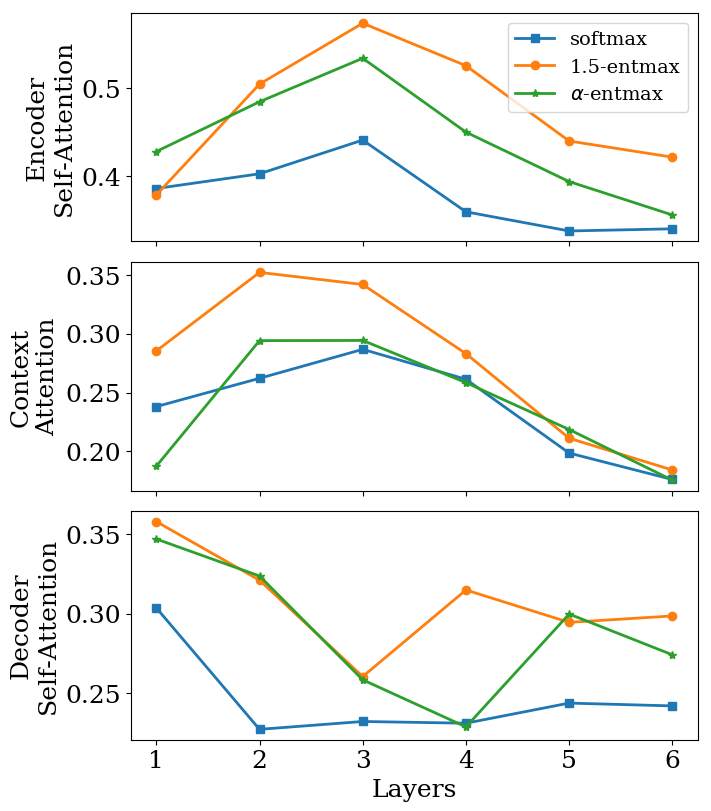

In [59]:
# cmap_d = [plt.cm.copper_r(k) for k in np.linspace(0, .9, 8)]
_, axes = plt.subplots(3, 1, figsize=(7, 8), sharey=False, sharex=True, constrained_layout=True)
ms = {'softmax': 's', '1.5-entmax': 'o', 'alpha-entmax': '*'}
for ax_i, attn_type in enumerate(attn_types):
    jsdiv_per_activation = jsdiv_per_attn_type[attn_type]
    ax = axes[ax_i]
    

    for ax_j, activation in enumerate(jsdiv_per_activation.keys()):
        
        m = ms[activation]
        
        js_divs = jsdiv_per_activation[activation]
        x_ = np.array(range(js_divs.shape[0]))
        x_ += 1
        
        if 'alpha' in activation:
            activation = r'$\alpha$-entmax'
        ax.plot(x_, js_divs, label=activation, lw=2, marker=m)
        # ax.set_ylim((0, 1))
        ax.set_xticks(x_)


axes[0].legend(fontsize=14)
print(attn_types)
labels = ['Encoder\nSelf-Attention', 'Context\nAttention', 'Decoder\nSelf-Attention']

for row, label in zip(axes, labels):
    row.set_ylabel(label)

axes[2].set_xlabel(r"Layers")
#plt.show()
plt.savefig('../figures/js_divs.pdf', bbox_inches='tight')

#### Positional Heads

In [45]:
attn_types = ['enc_self', 'dec_context', 'dec_self']
window_size = [-1, 0, 1]

positional_per_attn_type = {}
for attn_type in attn_types:

    positional_per_activation = {}

    for activation, dataset_attns in attns_per_example.items():
        hard_stat = np.zeros((3, 6, 8))
        soft_stat = np.zeros((3, 6, 8))
        sum_of_lens = 0

        for idx in tqdm(range(len(dataset_attns))):
            attn = dataset_attns[idx]['attn'][attn_type]
            if attn.ndim < 4:
                continue
            seq_size = attn.shape[-2]
            sum_of_lens += seq_size
            for kk, offset in enumerate(window_size):
                for ii, layer in enumerate(attn):
                    for jj, head in enumerate(layer):
                        timesteps = (np.arange(seq_size) + offset)
                        argmax_mask = (head.argmax(axis=-1) == timesteps)
                        hard_stat[kk, ii, jj] += argmax_mask.sum()
                        soft_stat[kk, ii, jj] += head.max(axis=-1)[argmax_mask].sum()

        hard_stat = hard_stat / sum_of_lens
        soft_stat = soft_stat / sum_of_lens
        
        positional_per_activation[activation] = {'hard_stat': hard_stat, 'soft_stat': soft_stat}
        
    positional_per_attn_type[attn_type] = positional_per_activation

100%|██████████| 3000/3000 [00:06<00:00, 450.36it/s]


In [46]:
for attn_type, positional_per_activation in positional_per_attn_type.items():
    print(attn_type)
    for activation, positional_data in positional_per_activation.items():
        print(activation)
        hard_stat = positional_data['hard_stat']
        soft_stat = positional_data['soft_stat']
        for kk, offset in enumerate(window_size):
            print("Offset: %i" % (offset))
            for ii, layer in enumerate(hard_stat[kk]):
                for jj, head in enumerate(layer):
                    if head > 0.9:
                        print(
                            'layer %i, head %i. Positional Head Role Certainty: %0.5f' % (
                                ii+1, jj+1, soft_stat[kk, ii, jj]))
                        if activation.startswith('alpha'):
                            print("alpha: ", alphas['enc_self'][ii][jj])
            print()

enc_self
softmax
Offset: -1
layer 1, head 5. Positional Head Role Certainty: 0.94235
layer 3, head 2. Positional Head Role Certainty: 0.93540
layer 3, head 3. Positional Head Role Certainty: 0.92077

Offset: 0

Offset: 1
layer 2, head 3. Positional Head Role Certainty: 0.95651

1.5-entmax
Offset: -1
layer 1, head 5. Positional Head Role Certainty: 0.94164
layer 2, head 3. Positional Head Role Certainty: 0.94483
layer 3, head 2. Positional Head Role Certainty: 0.94848

Offset: 0
layer 1, head 2. Positional Head Role Certainty: 0.89181
layer 1, head 6. Positional Head Role Certainty: 0.88980

Offset: 1
layer 2, head 8. Positional Head Role Certainty: 0.95852

alpha-entmax
Offset: -1
layer 1, head 2. Positional Head Role Certainty: 0.86046
alpha:  1.1843703
layer 2, head 6. Positional Head Role Certainty: 0.95889
alpha:  1.9037453
layer 2, head 8. Positional Head Role Certainty: 0.95880
alpha:  1.9092915
layer 3, head 4. Positional Head Role Certainty: 0.95376
alpha:  1.9713838

Offset: 0

#### Some random stuff

In [14]:
layer = 5
head = 4

for kk, offset in enumerate(window_size):
    print(
        'Layer %i, Head %i, Offset %i. Hard Stat %0.2f, Soft Stat %0.2f' % (
            layer, head, offset, hard_stat[kk, layer-1, head-1], soft_stat[kk, layer-1, head-1]))

Layer 5, Head 4, Offset -1. Hard Stat 0.27, Soft Stat 0.21
Layer 5, Head 4, Offset 0. Hard Stat 0.07, Soft Stat 0.07
Layer 5, Head 4, Offset 1. Hard Stat 0.00, Soft Stat 0.00


In [16]:
dataset_attns[0]

{'src': ['a',
  'Republi@@',
  'can',
  'strategy',
  'to',
  'counter',
  'the',
  're',
  '@-@',
  'election',
  'of',
  'Obama'],
 'tgt': ['<s>',
  'eine',
  'republi@@',
  'kanische',
  'Strategie',
  ',',
  'um',
  'der',
  'Wieder@@',
  'wahl',
  'von',
  'Obama',
  'entgegen@@',
  'zu@@',
  'treten',
  '</s>'],
 'attn': {'enc_self': array([[[[3.03442515e-02, 2.29581609e-01, 4.68003824e-02, ...,
            2.37752348e-02, 4.26557809e-02, 4.29717392e-01],
           [4.43331338e-02, 3.78931463e-01, 5.73939011e-02, ...,
            3.50010432e-02, 4.54894640e-02, 2.84085095e-01],
           [4.02718671e-02, 2.29181930e-01, 1.45094963e-02, ...,
            6.62125871e-02, 1.43421162e-02, 2.79365540e-01],
           ...,
           [8.85212570e-02, 6.57032579e-02, 2.48898640e-02, ...,
            1.05011754e-01, 7.68261552e-02, 1.93199724e-01],
           [5.41959144e-02, 1.38985664e-01, 4.07903269e-02, ...,
            4.96880151e-02, 4.00588550e-02, 3.53645563e-01],
           [2.

In [13]:
len([sent for sent in attns_per_example['alpha-entmax']
              if 7 < len(sent['src']) < 13])

409

# Visualize Short Sentences

In [ ]:
short_sent = [sent for sent in attns_per_example['alpha-entmax']
              if 5 < len(sent['src']) < 10 and sent['src'][-1] == '?' and 'who' in sent['src']]

In [ ]:
layer = 1
head = 3
attn_type = 'enc_self'

ixs_ = np.random.randint(0, len(short_sent), size=10)
for ix in ixs_:
    draw_plot(short_sent[ix], attn_type, layer, head)

In [27]:
interrogative_words = ['which', 'how', 'what', 'who', 'why', 'when', 'whose', 'whom', 'whether',
                       'should', 'could', 'can',
                       'are', 'were', 'am', 'is', 'was',
                       'do', 'did', 'does']

attn_type = 'enc_self'

interrogative_heads_per_activation = {}

for activation, dataset_attns in attns_per_example.items():

#    sents_with_interr = [sent for sent in dataset_attns
#                         if any(
#                             [int_word in [word.lower() for word in sent['src']]
#                              for int_word in interrogative_words])]

    counter = np.zeros((6, 8))
    normalizer = np.zeros((6, 8))

    for idx in tqdm(range(len(dataset_attns))):
        attn = dataset_attns[idx]['attn'][attn_type]
        src = dataset_attns[idx]['src']
        if attn.ndim < 4:
            continue

        for ii, layer in enumerate(attn):
            for jj, head in enumerate(layer):

                for tt, timestep in enumerate(head):
                    # print(src[tt])
                    
                    if src[tt].lower() in interrogative_words:
                        

                        if src[-1] == '?':
                            normalizer[ii, jj] += 1
                            if timestep.argmax() == len(src) - 1:
                                counter[ii, jj] += 1
#                         else:
#                             if timestep.argmax() != len(src) - 1:
#                                 counter[ii, jj] += 1


    interrogative_heads_per_activation[activation] = counter / normalizer

100%|██████████| 3000/3000 [00:01<00:00, 1852.07it/s]


In [43]:
for act in ['softmax', '1.5-entmax', 'alpha-entmax']:
    print(act)
    X = interrogative_heads_per_activation[act]
    ix = np.argsort(X.ravel())[::-1][:4]
    for i in ix:
        ii, jj = np.unravel_index(i, X.shape)
        print(ii, jj, X[ii, jj], alphas['enc_self'][ii][jj])
        
    # print(np.dstack(np.unravel_index(np.argsort(X.ravel()), X.shape)))
    # print(interrogative_heads_per_activation[act].shape)

softmax
0 3 0.9850746268656716 1.912102
3 3 0.9601990049751243 1.1355212
5 1 0.845771144278607 1.2356246
5 6 0.8258706467661692 1.3387105
1.5-entmax
0 3 0.9701492537313433 1.912102
5 7 0.8756218905472637 1.1005207
4 5 0.8557213930348259 1.2005359
3 3 0.8258706467661692 1.1355212
alpha-entmax
0 2 0.9950248756218906 1.0500289
3 7 0.9601990049751243 1.1161383
3 2 0.9253731343283582 1.1053005
5 3 0.9054726368159204 1.1327242


In [ ]:
for attn_type, positional_per_activation in positional_per_attn_type.items():
    if attn_type != 'enc_self':
        continue
    print(attn_type)
    for activation, positional_data in positional_per_activation.items():
        print(activation)
        hard_stat = positional_data['hard_stat']
        soft_stat = positional_data['soft_stat']
        for kk, offset in enumerate(window_size):
            print("Offset: %i" % (offset))
            for ii, layer in enumerate(hard_stat[kk]):
                for jj, head in enumerate(layer):
                    if head > 0.9:
                        print(
                            'layer %i, head %i. Positional Head Role Certainty: %0.2f' % (
                                ii+1, jj+1, soft_stat[kk, ii, jj]))

        sents_with_interr = [sent for sent in attns_per_example[activation]
                     if any(
                         [int_word in [word.lower() for word in sent['src']]
                          for int_word in interrogative_words])]

                    
                    if interrogative_head > 0.9:
                        print('Interrogative! layer %i, head %i.' % (ii+1, jj+1))

In [ ]:
interrogative_head

#### incomplete

In [ ]:
layer = 4
head = 6

for kk, offset in enumerate(window_size):
    print(
        'Layer %i, Head %i, Offset %i. Hard Stat %0.2f, Soft Stat %0.2f' % (
            layer, head, offset, hard_stat[kk, layer-1, head-1], soft_stat[kk, layer-1, head-1]))
draw_plot(dataset_attns[200], 'enc_self', layer, head)

In [ ]:
with open(stats_dict['softmax'], 'rb') as f:
    softmax_dataset_attns = pickle.load(f)

In [ ]:
draw_plot(softmax_dataset_attns[100], 'enc_self', 1, 2)